# Demo: Uso de modelos de inteligencia artificial en Python con la librería transformers (Hugging Face)

En esta demo aprenderemos cómo usar modelos de inteligencia artificial en Python utilizando la librería transformers de Hugging Face (ente otras).

## Introducción
- Aplicar una nueva arquitectura de modelo de inteligencia artificial para resolver una tarea manualmente puede ser complicado y costoso en términos de tiempo y recursos.
- La librería transformers de la compañía Hugging Face es una librería de Python que proporciona una API fácil de usar para utilizar un amplio catálogo de modelos de inteligencia artificial de última generación.
- Entre las tareas que se pueden realizar con transformers se encuentran la clasificación de texto, la generación de texto, la traducción de texto, la extracción de información, generación de imágenes, entre otras.

## Librerías o dependencias de Python necesarias
Para poder ejecutar este notebook necesitarás tener instaladas las siguientes librerías de Python:

- Transformers: `transformers`
- Pytorch: `torch torchvision torchaudio`
- *Jupyter Notebook (Opcional): `ipykernel ipywidgets`

Puedes instalarlas ejecutando el siguiente comando en tu terminal:
```bash
pip install jupyter ipykernel ipywidgets transformers torch torchvision torchaudio diffusers accelerate python-dotenv
```

*Más información en:*
- *Transformers*: https://huggingface.co/docs/transformers/en/installation
- *Pytorch*: https://pytorch.org/get-started/locally/

In [1]:
#!pip install jupyter ipykernel ipywidgets transformers torch torchvision torchaudio

### Otras dependencias usadas en esta sesion
Aparte de las librerías mencionadas anteriormente, también usaremos otras librerías que aportarán funcionalidades adicionales. Estas librerías son:

```bash
pip install gradio phonemizer timm matplotlib
```

In [2]:
# !pip install gradio phonemizer timm matplotlib

In [1]:
import os
import gc
from IPython.display import Audio as IPythonAudio
from IPython.display import Image as IPImage
from pprint import pprint
from PIL import Image
import requests
import io
from io import BytesIO

from transformers import (
    pipeline,
    BlipForImageTextRetrieval,
    AutoProcessor,
    BlipForConditionalGeneration,
    BlipForQuestionAnswering,
    CLIPModel
    )

from diffusers import (
    DiffusionPipeline,
    StableDiffusionPipeline,
    DPMSolverMultistepScheduler)
from dotenv import load_dotenv
from huggingface_hub import login
import torch
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

## Jupyter Notebooks

- Jupyter Notebook es una aplicación web de código abierto que te permite crear y compartir documentos que contienen código en vivo, ecuaciones, visualizaciones y texto explicativo
- Los usos incluyen: limpieza y transformación de datos, simulación numérica, estadísticas, aprendizaje automático y mucho más.
  
Para instalar Jupyter Notebook, ejecuta:

```bash
pip install jupyter
```

Para ejecutar Jupyter Notebook, ejecuta:

```bash
jupyter notebook
```

También puede utilizarse a través de la extensión de Jupyter en Visual Studio Code (recomendado) disponible en su marketplace de extensiones.

## Modelos de inteligencia artificial

Los modelos de inteligencia artificial son modelos que han sido entrenados para realizar tareas específicas, como clasificación de texto/audio/imagenes, generación de texto/audio/imagenes, etc.


## Huggingface

Hugging Face es una empresa que ha desarrollado una plataforma de inteligencia artificial y una librería de código abierto para modelos de inteligencia artificial llamada **transformers**.

La librería transformers de Hugging Face proporciona una API fácil de usar para usar modelos de inteligencia artificial de última generación.


A fecha de Diciembre 2024, no es necesario tener una cuenta en Hugging Face para usar la librería transformers y utilizar su API, pero es recomendable tener una cuenta para poder acceder a más funcionalidades.

In [3]:
# Para poder logearte en la API de Hugging Face
# Algunas acciones y modelos requieren autenticación

load_dotenv()  # Carga las variables de entorno desde el archivo .env

HF_TOKEN = os.getenv('HF_TOKEN')  # Token de Hugging Face

login(token=HF_TOKEN)  # Logearte en la API de Hugging Face

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/sergio.sampayo/.cache/huggingface/token
Login successful


## Uso de la GPU

El uso de la GPU es opcional, pero se recomienda para acelerar el procesamiento de los modelos.
- La libreria torch (Pytorch) permite usar la GPU para acelerar el procesamiento de los modelos.
- Para usar la GPU, asegúrate de tener instalado los drivers de la GPU y la versión de CUDA compatible con la versión de Pytorch que estás usando.
- Puedes verificar si tienes una GPU disponible con el comando `!nvidia-smi` o `torch.cuda.is_available()`.
- Puedes especificar el dispositivo de la GPU con el parámetro `device=0` o `device=1` o simplemente con `device='cuda'`.
- Usa una precisión de 16 puntos flotantes (FP16) para acelerar el procesamiento de los modelos (si es posible) con el parámetro `torch_dtype=torch.float16` https://huggingface.co/docs/transformers/en/main_classes/pipelines

In [4]:
torch.cuda.is_available()

True

In [5]:
if torch.cuda.is_available():
    torch.cuda.current_device()

In [6]:
if torch.cuda.is_available():
    torch.cuda.get_device_name(0)

In [7]:
!nvidia-smi

Fri Dec 20 09:31:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P3             13W /   30W |       3MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

## Uso simple de modelos de inteligencia artificial en Huggingface: inferencia de modelos con Pipelines

- La API de Transformers posee diferentes niveles de abstracción, desde el uso sencillo de modelos pre-entrenados para tareas específicas hasta la creación de modelos personalizados.
- La forma más sencilla de usar un modelo de inteligencia artificial en Huggingface es a través de un `pipeline`.
- Un `pipeline` es una clase que admite como parámetro de entrada un modelo pre-entrenado del Hub de HuggingFace y proporciona una API fácil de usar para realizar tareas específicas a través de inferencias.
- Algunas tareas que pueden realizarse son: `translation`, `text-generation`, `summarization`, `question-answering`,  `speech-recognition`, `speech-to-text`, etc.

In [11]:
# Reproducibility
# SEED = 42
# torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True)

### Importar y usar la clase `pipeline` de la librearía `transformers`

- Elige una tarea específica a realizar con un modelo de inteligencia artificial: translation, text-generation, summarization, question-answering, speech-recognition, speech-to-text, ... (https://huggingface.co/transformers/task_summary.html)
- Elige un modelo pre-entrenado que pueda realizar esa tarea específica: 
  - https://huggingface.co/models
  - Con Python: https://huggingface.co/blog/searching-the-hub
  - Ten en cuenta la fecha de publicación, tamaño, precisión, etc.
  - El pipeline descargará automáticamente el modelo pre-entrenado si no está disponible localmente.
- *Opcional: elige un dispositivo GPU para acelerar el procesamiento del modelo.
- *Opcional: elige una precisión de 16 puntos flotantes (FP16) para acelerar el procesamiento del modelo.

Ejemplo: `"text-classification"` pipeline (chat bot):

In [10]:
pipe = pipeline("text-classification",  # tarea a realizar
                model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",  # modelo a utilizar
                device=device,   # dispositivo a utilizar
                torch_dtype=torch.bfloat16,)   # precisión de los cálculos

Device set to use cuda


### Usar un pipeline

In [13]:
text = "You are wrong and I am not in the mood to discuss this with you."
response = pipe(text)  # inferencia del modelo
print(response)

[{'label': 'NEGATIVE', 'score': 0.9990600943565369}]


#### Usar un pipeline: Gradio app

Pipelines es compatibles automáticamente con Gradio, una biblioteca que facilita la creación de aplicaciones de aprendizaje automático.

In [11]:
demo = gr.Interface.from_pipeline(pipe)  # Crear una interfaz de usuario para el modelo

demo.launch()  # Lanzar la interfaz de usuario

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


#### Crear una app en Huggingface Spaces

Gradio también es compatible con Huggingface Spaces, una plataforma de colaboración para proyectos de inteligencia artificial.
1. Crea un nuevo Space para Gradio: https://huggingface.co/new-space
2. Clona el repositorio creado (direccion proporcionada al crear el Space)
3. Crea tu app de Gradio en el archivo `app.py`:
    ```python
    import gradio as gr
    import torch
    from transformers import pipeline


    pipe = pipeline("text-classification",  # tarea a realizar
                model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",  # modelo a utilizar
                torch_dtype=torch.bfloat16,)   #


    def text_classification(text):
        result = pipe(text)
        return result[0]['label']


    examples = ['You are the evil!', 'Doing great boy!']

    demo = gr.Interface(fn=text_classification,
                        inputs= gr.Textbox(lines=2, label="Text", placeholder="Enter text here..."), 
                        outputs=gr.Textbox(lines=2, label="Text Classification Result"),
                        description="Enter a text and see the sentiment classification result!",
                        examples=examples,
                        title="Sentiment Classification")

    demo.launch()
    ```

4. Añade un archivo `requirements.txt` con las dependencias necesarias
    ```
    gradio
    torch
    transformers
    ```

5. Actualiza tu repositorio:
    ```python
    git add app.py requirements.txt
    git commit -m "Add application file"
    git push  # requiere autenticación con token con permisos de escritura
    ```

In [12]:
pipe = None

###  Tareas

Algunas de las tareas que se pueden realizar importando modelos pre-entrenados de Huggingface son:

Texto/NLP o Natural Language Processing:
- Text classification
- Question answering
- Summarization
- Translation
- Language modeling
- etc.

Audio
- Speech recognition
- etc.

Computer Vision
- Image classification
- Object detection
- etc.

Más información en : [Task summary](https://huggingface.co/docs/transformers/task_summary)

### Texto/NLP o Natural Language Processing

#### Text Classification

- Clasificación de texto: clasificar un texto en una o más categorías.


In [13]:
pipe = pipeline("text-classification",
                model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
                device=device,
                torch_dtype=torch.bfloat16,)

text = "You are wrong and I am not in the mood to discuss this with you."
response = pipe(text)

Device set to use cuda


In [14]:
response

[{'label': 'NEGATIVE', 'score': 0.9990600943565369}]

#### Question Answering

- Question Answering: responder a preguntas basadas en un contexto.


In [15]:
pipe = pipeline("question-answering",
                model="deepset/roberta-base-squad2",
                device=device,)
QA_input = {
    'question': 'Is the Earth flat or round?',
    'context': 'There is no doubt that the Earth is round. The evidence is overwhelming.'
}

response = pipe(QA_input)

Device set to use cuda
/home/sergio.sampayo/.cache/pypoetry/virtualenvs/workshop-python-entornos-profesionales-VgxNFXIN-py3.11/lib/python3.11/site-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(


In [16]:
response

{'score': 0.8745290040969849, 'start': 36, 'end': 41, 'answer': 'round'}

#### Translation

- Traducción de texto de un idioma a otro.

*Acrónimos de lenguas para utilizar en el modelo: https://huggingface.co/facebook/nllb-200-distilled-600M/blob/main/README.md*

In [17]:
pipe = pipeline("translation",
                model="facebook/nllb-200-distilled-600M",
                device=device,
                torch_dtype=torch.bfloat16,
                src_lang="spa_Latn", # idioma de origen
                tgt_lang="fra_Latn") # idioma de destino

text = "El golpe de la langosta mantis causa sonoluminiscencia a partir del colapso de la burbuja. Esto produce durante un intervalo tremendamente corto una cantidad muy pequeña de luz y una temperatura de miles de grados dentro de la burbuja que colapsa. "
response = pipe(text)

Device set to use cuda


In [18]:
print(response[0]['translation_text'])

Le choc du langost mantis provoque une sonoluminisation à partir de l'effondrement de la bulle, ce qui produit pendant un intervalle extrêmement court une très petite quantité de lumière et une température de milliers de degrés à l'intérieur de la bulle qui s'effondre. 


In [19]:
pipe = pipeline("translation",
                model="facebook/nllb-200-distilled-600M",
                device=device,
                torch_dtype=torch.bfloat16,
                src_lang="spa_Latn",
                tgt_lang="eng_Latn")

response = pipe(text)

Device set to use cuda


In [20]:
print(response[0]['translation_text'])

The mantis lobster's impact causes sonoluminescence from the bubble collapse, which produces during a tremendously short interval a very small amount of light and a temperature of thousands of degrees inside the bubble that collapses.


In [21]:
pipe = None
gc.collect() 

16099

#### Summarization

- Resumen de texto.

In [22]:
summarizer = pipeline(task="summarization",
                      model="facebook/bart-large-cnn",
                      device=device,
                      torch_dtype=torch.bfloat16,)

Device set to use cuda


In [23]:
text = """Paris is the capital and most populous city of France, with
          an estimated population of 2,175,601 residents as of 2018,
          in an area of more than 105 square kilometres (41 square
          miles). The City of Paris is the centre and seat of
          government of the region and province of Île-de-France, or
          Paris Region, which has an estimated population of
          12,174,880, or about 18 percent of the population of France
          as of 2017."""
          
summary = summarizer(text,
                     min_length=10,
                     max_length=100,)

In [24]:
summary[0]['summary_text']

'Paris is the capital and most populous city of France, with an estimated population of 2,175,601 residents as of 2018. The City of Paris is the centre and seat of the government of the region and province of Île-de-France.'

In [25]:
summarizer = None
gc.collect() 

232

#### Modelos generativos de texto

- Generación de texto.
- Completar texto.
- Conversación.
- etc.

*temperature*: controla la aleatoriedad de la generación de texto. Un valor más alto produce texto más creativo, pero menos coherente. Un valor más bajo produce texto más coherente, pero menos creativo.

In [29]:
pipe = pipeline(task="text-generation",
                model="meta-llama/Llama-3.2-1B",
                max_length=500,
                truncation=True,
                temperature=0.9,
                device='cpu')

response = pipe("Continue the tale: Once upon a time, there was a little...")

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [30]:
pprint(response[0]['generated_text'])

("Continue the tale: Once upon a time, there was a little... well, I don't "
 'know, something in the woods... and it was afraid of me. And then there was '
 'a girl who was nice to it... but not too nice, because it was afraid of her. '
 'And then there was a man who was a monster... who was really just a man, but '
 "who didn't seem to know that.\n"
 'Oh, and there was a little girl... and there was a boy, and there was a girl '
 'who was nice to them both... but not too nice, because they were afraid of '
 'her. And there was a man who was a monster... who was really just a man, but '
 "who didn't seem to know that.\n"
 'A little boy, a little girl, a man, and a monster. It all starts with a '
 "little mouse who lives in a hollow tree. The little boy's father makes a "
 'house for him and the little girl and her mother and their father make a '
 'house for the little boy and the little girl and their father. But the '
 'little mouse is lonely. The little boy and the little girl love

In [31]:
response = pipe("Continue the tale: Once upon a time, there was a little...")
pprint(response[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


('Continue the tale: Once upon a time, there was a little... [Age 11+] girl '
 'who was pretty sure she wanted to be an artist. Her father, a self-employed '
 'carpenter, was so inspired by the many pieces his daughter created that he '
 'eventually decided to put his dream into action by taking a class at the '
 'local art school. It was this first experience that motivated her to '
 'continue her passion for art and started her on a lifelong journey. "I was '
 'completely inspired by my instructor and her commitment to her craft. She '
 'was one of those artists that made me want to be an artist."')


In [32]:
pipe = pipeline(task="text-generation",
                model="meta-llama/Llama-3.2-1B",
                max_length=500,
                truncation=True,
                temperature=0.01,
                device='cpu')

response = pipe("Continue the tale: Once upon a time, there was a little...")
pprint(response[0]['generated_text'])

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


('Continue the tale: Once upon a time, there was a little... girl. She was '
 'born with a special gift. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She 

In [33]:
response = pipe("Continue the tale: Once upon a time, there was a little...")
pprint(response[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


('Continue the tale: Once upon a time, there was a little... girl. She was '
 'born with a special gift. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She could see the future. She could see the past. '
 'She could see the present. She 

In [34]:
pipe = pipeline(task="text-generation",
                model="meta-llama/Llama-3.2-1B",
                max_length=500,
                truncation=True,
                temperature=0.2,
                device='cpu')

response = pipe("Continue the tale: Once upon a time, there was a little...")
pprint(response[0]['generated_text'])

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


('Continue the tale: Once upon a time, there was a little... girl. She was '
 'born in a small town in the middle of nowhere. She was the only child of her '
 'parents, and they were very proud of her. She was a beautiful girl, with '
 'long, dark hair and blue eyes. Her parents were very strict, but they loved '
 'her dearly. They taught her to be kind and gentle, and to always do what was '
 'right. They also taught her to be strong, and to never give up. She was a '
 'strong girl, and she knew it. She was a little bit different from other '
 'girls her age, but she was still a girl. She had a lot of friends, and she '
 'was always happy. She loved to play with her friends, and she loved to go on '
 'adventures with them. She was a brave girl, and she knew that she could do '
 'anything she wanted to. She was a strong girl, and she knew that she could '
 'do anything she wanted to. She was a brave girl, and she knew that she could '
 'do anything she wanted to. She was a strong girl,

In [35]:
pipe = None
gc.collect() 

0

### Audio

Huggingface dispone de modelos pre-entrenados para tareas de audio:
- Automatic Speech Recognition (ASR)
- Speech-to-Text (STT)
- Text-to-Speech (TTS)
- etc.

#### Audio Classification

- Etiqueta datos en formato audio con unas clases predefinidas.

In [36]:
classifier = pipeline(task="audio-classification",
                      model="superb/hubert-base-superb-er",
                      device=device,)
preds = classifier("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac")
preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]

Device set to use cuda


In [37]:
preds

[{'score': 0.4532, 'label': 'hap'},
 {'score': 0.3622, 'label': 'sad'},
 {'score': 0.0943, 'label': 'neu'},
 {'score': 0.0903, 'label': 'ang'}]

In [38]:
classifier = None
gc.collect() 

132

#### Automatic Speech Recognition (ASR)

- Reconocimiento automático de voz: permite convertir el habla humana en texto.

In [39]:
transcriber = pipeline(task="automatic-speech-recognition",
                       model="openai/whisper-small",
                       device=device,
                       torch_dtype=torch.bfloat16,)
transcriber("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac")

Device set to use cuda
/home/sergio.sampayo/.cache/pypoetry/virtualenvs/workshop-python-entornos-profesionales-VgxNFXIN-py3.11/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'text': ' I have a dream that one day this nation will rise up and live out the true meaning of its creed.'}

In [40]:
transcriber("https://www.myinstants.com/media/sounds/el-alcalde.mp3")

/home/sergio.sampayo/.cache/pypoetry/virtualenvs/workshop-python-entornos-profesionales-VgxNFXIN-py3.11/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


{'text': ' Es el vecino el que elige al alcalde y es el alcalde el que quiere que sean los vecinos el alcalde.'}

In [41]:
gr.Interface.from_pipeline(transcriber).launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b391637fec756c55fc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [42]:
demo = gr.Blocks()

def transcribe_speech(filepath: str) -> str:
    if filepath is None:
        gr.Warning("No audio found, please retry.")
        return ""
    output = transcriber(filepath)
    return output["text"]

file_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="upload",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    flagging_mode="never")

mic_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="microphone",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    flagging_mode="never")

In [43]:
with demo:
    gr.TabbedInterface(
        [file_transcribe,
         mic_transcribe],
         ["Transcribe Audio File",
          "Transcribe Microphone Audio"],
    )

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://773b387199a2fae0ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [44]:
demo.close()

Closing server running on port: 7862


In [45]:
transcriber = None
gc.collect() 

56657

#### Text to speech

Convierte texto en audio.

In [46]:
narrator = pipeline(task="text-to-speech",
                    model="kakao-enterprise/vits-ljs",
                    device=device,)

text = """
It began with the forging of the Great Rings. \
Three were given to the Elves, immortal, wisest and fairest of all beings. \
Seven to the Dwarf-Lords, great miners and craftsmen of the mountain halls. \
And nine, nine rings were gifted to the race of Men, who above all else desire power.
"""

narrated_text = narrator(text)

Device set to use cuda


In [47]:
narrated_text

{'audio': array([[-0.00120147, -0.00146782, -0.00187161, ..., -0.00099709,
         -0.00105924, -0.00101383]], shape=(1, 399616), dtype=float32),
 'sampling_rate': 22050}

In [48]:
IPythonAudio(narrated_text["audio"][0],
             rate=narrated_text["sampling_rate"])

In [49]:
narrator = None
gc.collect() 

6436

### Computer Vision

Huggingface también proporciona modelos pre-entrenados para tareas de visión por computadora:
- Image classification
- Object detection
- etc.

#### Object Detection

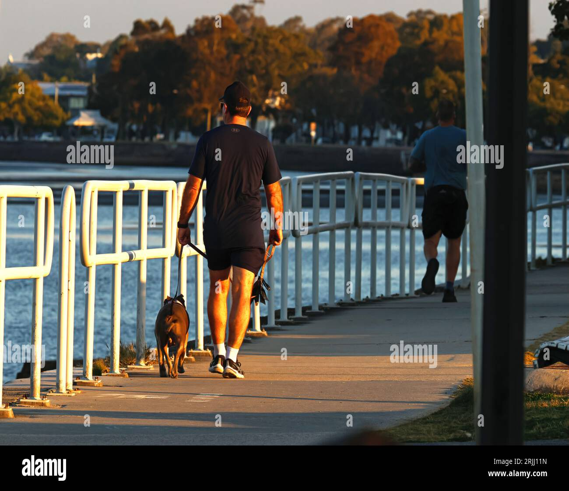

In [50]:
url = 'https://c8.alamy.com/comp/2RJJ11N/random-man-guy-people-walking-a-dog-man-running-away-from-the-camera-no-faces-sports-healthy-living-2RJJ11N.jpg'
response = requests.get(url)
raw_image = Image.open(BytesIO(response.content))
raw_image.resize((569, 491))

In [51]:
def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

In [52]:

od_pipe = pipeline(task="object-detection",
                   model="facebook/detr-resnet-50",
                   device=device)
pipeline_output = od_pipe(raw_image)
processed_image = render_results_in_image(
    raw_image, 
    pipeline_output)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda


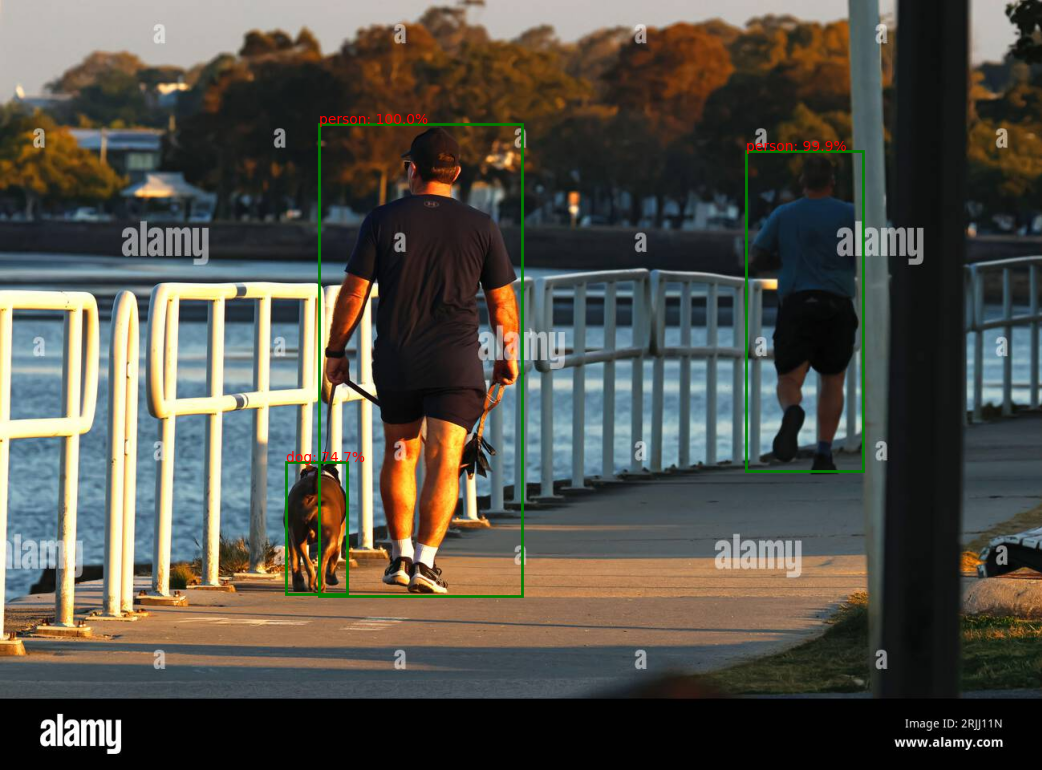

In [53]:
processed_image

In [54]:
def get_pipeline_prediction(pil_image):
    
    pipeline_output = od_pipe(pil_image)
    
    processed_image = render_results_in_image(pil_image,
                                            pipeline_output)
    return processed_image

In [55]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image", 
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://974133b4cf9fa1b969.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [56]:
demo.close()

Closing server running on port: 7862


In [57]:
od_pipe = None
gc.collect() 

16361

#### Image Segmentation

In [58]:
torch.cuda.empty_cache()
gc.collect()

236

In [59]:
segmentation_pipe = pipeline(task="mask-generation",
                             model="Zigeng/SlimSAM-uniform-77",
                             device=device)

output = segmentation_pipe(raw_image, points_per_batch=32)

Device set to use cuda


In [60]:
output

{'masks': [array([[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]], shape=(960, 1300)),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False],
         [False, False, False, ..., False, False, False]], shape=(960, 1300)),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., F

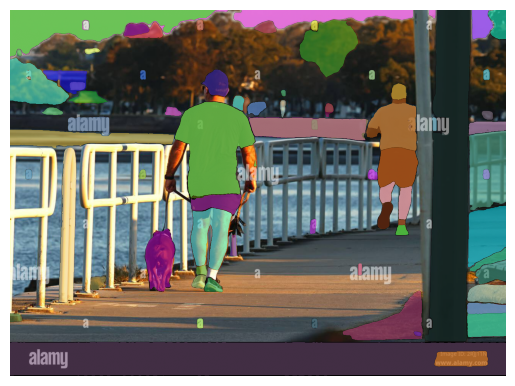

In [61]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_pipe_masks_on_image(raw_image, outputs):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    for mask in outputs["masks"]:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    
show_pipe_masks_on_image(raw_image, output)

In [ ]:
segmentation_pipe = None
torch.cuda.empty_cache()
gc.collect()

7867

### Modelos generativos en Computer Vision

- Text-to-Image
- Image-to-Text
- Image-to-Image
- Image-to-Video
- Image-to-3D
- Text-to-3D
- etc.

#### Text-to-Image

- Stable Diffusion es un modelo de aprendizaje profundo diseñado para generar imágenes a partir de descripciones textuales.
- Es una red de difusión latente que transforma ruido aleatorio en imágenes coherentes y detalladas, guiándose por indicaciones de texto. 

In [ ]:
# model_id = "stabilityai/stable-diffusion-2-1"

# # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path=model_id,
#                                                torch_dtype=torch.float16,)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to(device)

# prompt = "space opera cowboy, vintage, detailed, 4k"
# image = pipe(prompt).images[0]
    
# image.save("space_opera_cowboy_1.png")


In [11]:

IPImage(url='space_opera_cowboy_1.png') 

In [13]:
pipe = None
torch.cuda.empty_cache()
gc.collect()

650

#### Text-to-3D

- OpenAI Shap-E es un modelo de inteligencia artificial diseñado para la generación de representaciones 3D a partir de descripciones textuales o imágenes.
- A diferencia de modelos tradicionales que generan formas explícitas como mallas, Shap-E produce representaciones implícitas que pueden ser renderizadas de manera eficiente desde múltiples perspectivas.

In [ ]:
# import torch
# from diffusers import ShapEPipeline
# from diffusers.utils import export_to_gif


# ckpt_id = "openai/shap-e"
# pipe = ShapEPipeline.from_pretrained('openai/shap-e').to(device)


# guidance_scale = 15.0
# prompt = "a sumo penguin"
# images = pipe(
#     prompt,
#     guidance_scale=guidance_scale,
#     num_inference_steps=32,
#     frame_size=128
# ).images


The config attributes {'renderer': ['shap_e', 'ShapERenderer']} were passed to ShapEPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'renderer': ['shap_e', 'ShapERenderer']} are not expected by ShapEPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/sergio.sampayo/.cache/huggingface/hub/models--openai--shap-e/snapshots/7bd337afdea1c17842e1c3cc45c4e268356dba40/prior: Error no file named diffusion_pytorch_model.safetensors found in directory /home/sergio.sampayo/.cache/huggingface/hub/models--openai--shap-e/snapshots/7bd337afdea1c17842e1c3cc45c4e268356dba40/prior.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/sergio.sampayo/.cache/huggingface/hub/models--openai--shap-e/snapshots/7bd337afdea1c17842e1c3cc45c4e268356dba40/shap_e_renderer: Error no file named diffusion_pytorch_model.safetensors found in directory /home/sergio.sampayo/.cache/huggingface/hub/models--openai--shap-e/snapshots/7bd337afdea1c17842e1c3cc45c4e268356dba40/shap_e_renderer.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/63 [00:00<?, ?it/s]

In [15]:
# gif_path = export_to_gif(images[0], "penguin_3d.gif")

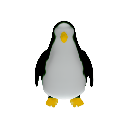

In [17]:

IPImage('penguin_3d.gif') 

## Ejemplos de uso de modelos de inteligencia artificial en Huggingface (sin la clase pipeline)

#### Image Retrieval (multimodal models: image-text matching)

- Multimodal models son modelos que pueden procesar tanto texto como imágenes, videos, audio, etc.
- Tareas para modelos multimodales:
    - Image-text matching
    - Image captioning
    - Visual question answering
    - etc.


*Mas informacion en: https://huggingface.co/learn/computer-vision-course/en/unit4/multimodal-models/a_multimodal_world*

In [ ]:
# Más información de Blip: https://huggingface.co/docs/transformers/en/model_doc/blip
model = BlipForImageTextRetrieval.from_pretrained(
    pretrained_model_name_or_path="Salesforce/blip-itm-base-coco")

processor = AutoProcessor.from_pretrained(
    pretrained_model_name_or_path="Salesforce/blip-itm-base-coco")

In [50]:
text = "an image of a man walking a dog on a bridge"

inputs = processor(images=raw_image,
                   text=text,
                   return_tensors="pt")

itm_scores = model(**inputs)[0]
itm_score = torch.nn.functional.softmax(
    itm_scores,dim=1)

print(f"""\
The image and text are matched \
with a probability of {itm_score[0][1]:.4f}""")

The image and text are matched with a probability of 0.7756


In [51]:
text = "an image of a woman running in the city"

inputs = processor(images=raw_image,
                   text=text,
                   return_tensors="pt")

itm_scores = model(**inputs)[0]
itm_score = torch.nn.functional.softmax(
    itm_scores,dim=1)

print(f"""\
The image and text are matched \
with a probability of {itm_score[0][1]:.4f}""")

The image and text are matched with a probability of 0.0001


In [52]:
model = None
processor = None
gc.collect()

0

#### Image Captioning

Toma una imagen y genera una descripción textual de la imagen.

In [ ]:
# Más información de Blip: https://huggingface.co/docs/transformers/en/model_doc/blip
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base")

processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base")

In [54]:
# Conditional
text = "a photograph of"
inputs = processor(raw_image, text, return_tensors="pt")
out = model.generate(**inputs)

print(processor.decode(out[0], skip_special_tokens=True))

a photograph of a man walking his dog along the river in the evening - stock image


In [55]:
# Unconditional
inputs = processor(raw_image, return_tensors="pt")
out = model.generate(**inputs)

print(processor.decode(out[0], skip_special_tokens=True))

a man walking his dog along the river in the evening - stock image


In [56]:
model = None
processor = None
gc.collect()

184

#### Visual Question Answering

Toma una imagen y genera una descripción textual de la imagen.

In [ ]:
# Más información de Blip: https://huggingface.co/docs/transformers/en/model_doc/blip
model = BlipForQuestionAnswering.from_pretrained(
    "Salesforce/blip-vqa-base")

processor = AutoProcessor.from_pretrained(
    "Salesforce/blip-vqa-base")

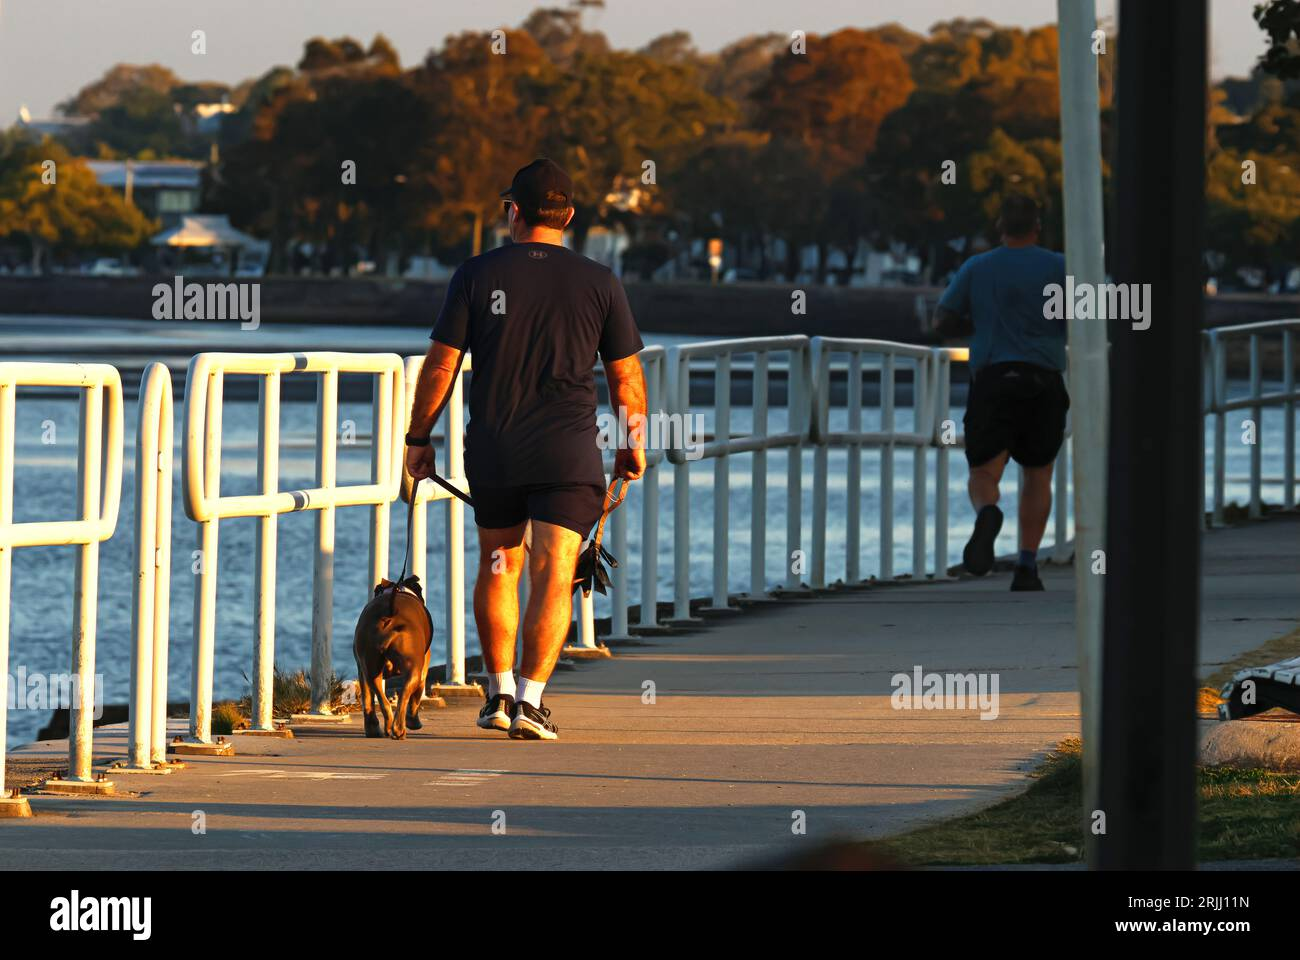

In [58]:
raw_image

In [59]:
question = "how many dogs are in the picture?"
inputs = processor(raw_image, question, return_tensors="pt")
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

2


In [60]:
model = None
processor = None
gc.collect()

145

#### Zero-Shot Image Classification

Consists of classifying an image without any training on the target classes.
- Pass the custom labels to the model.


In [ ]:
# Mas informacion de CLIPModel: https://huggingface.co/docs/transformers/en/model_doc/clip
model = CLIPModel.from_pretrained(
    pretrained_model_name_or_path="openai/clip-vit-large-patch14")

processor = AutoProcessor.from_pretrained(
    pretrained_model_name_or_path="openai/clip-vit-large-patch14")

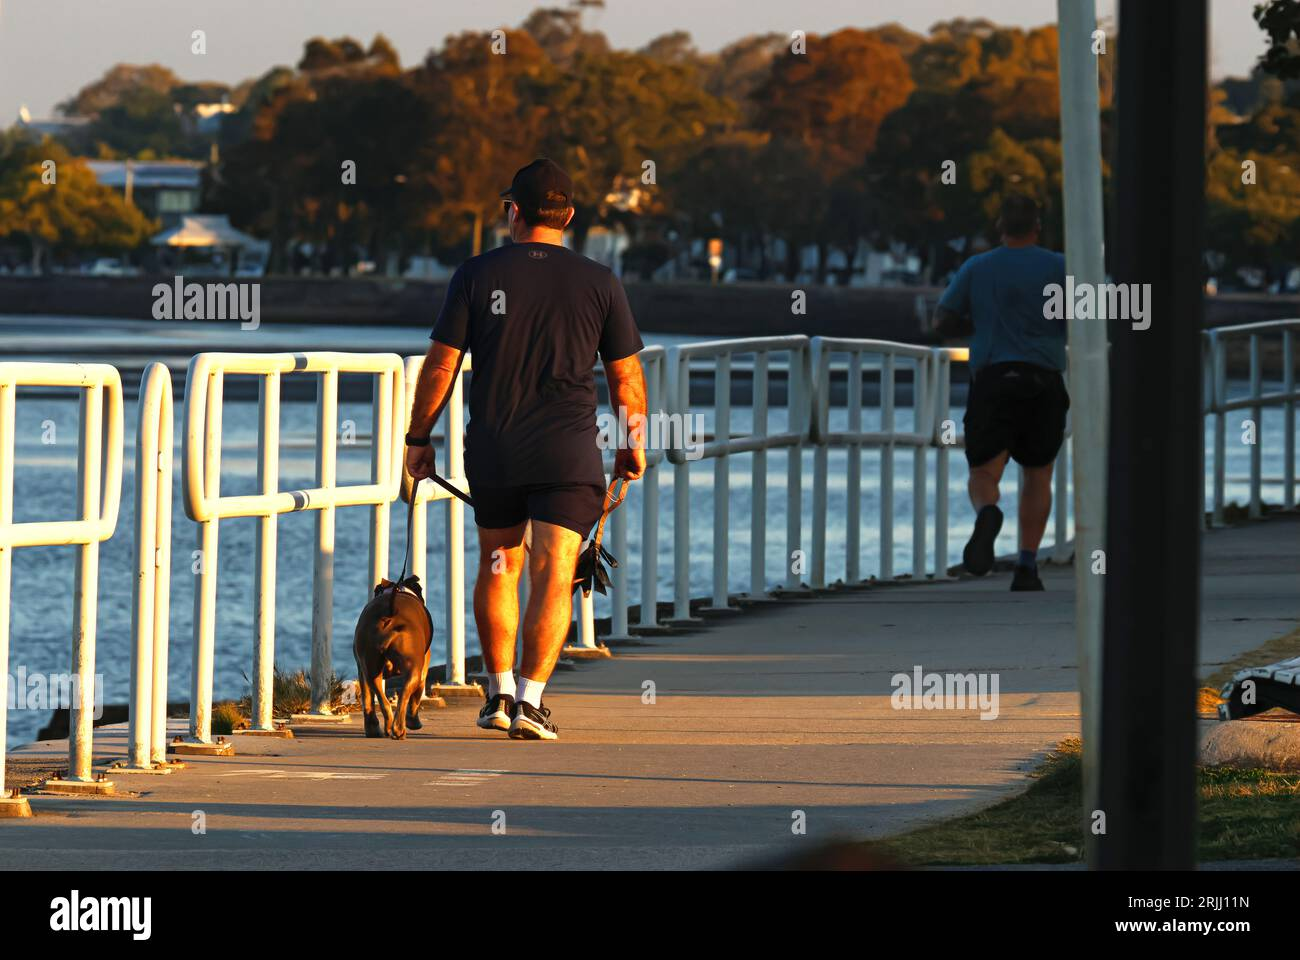

In [62]:
raw_image

In [63]:
labels = ["a photo of a cat", "a photo of a dog"]

inputs = processor(text=labels,
                   images=raw_image,
                   return_tensors="pt",
                   padding=True)

outputs = model(**inputs)
probs = outputs.logits_per_image.softmax(dim=1)[0]

In [64]:
probs = list(probs)
for i in range(len(labels)):
    print(f"label: {labels[i]} - probability of {probs[i].item():.4f}")

label: a photo of a cat - probability of 0.0054
label: a photo of a dog - probability of 0.9946


In [65]:
model = None
processor = None
gc.collect()

0